In [21]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import h5py

LOAD AND ANALYZE DATA

In [2]:
# Loading the data back from the HDF5 file
with h5py.File(r'D:\Hanze_Master\Thesis\Data\Capture24_seq\X_30.h5', 'r') as f:
    X = f['X_30'][:]
    print(X.shape)  # Check the shape of the loaded data

(1856443, 3, 150)


In [3]:
Y = np.load(r'D:\Hanze_Master\Thesis\Data\Capture24_seq\Y_WillettsSpecific2018.npy')
# Y = np.load(r'D:\Hanze_Master\Thesis\Data\Capture24_seq\Y_anno.npy', allow_pickle=True)
Y.shape

(1856443,)

In [4]:
nan_indices = np.load('nan_indices.npy')
nan_indices.shape

(12888,)

In [5]:
X = np.delete(X, nan_indices, axis=0)
Y =  np.delete(Y, nan_indices, axis=0)
X.shape, Y.shape

((1843555, 3, 150), (1843555,))

In [6]:
unique_labels, counts = np.unique(Y, return_counts=True)
print("Labels: ", unique_labels)
print("Counts: ", counts)
print("Amount of Labels is: ", len(unique_labels))

Labels:  ['bicycling' 'household-chores' 'manual-work' 'mixed-activity' 'sitting'
 'sleep' 'sports' 'standing' 'vehicle' 'walking']
Counts:  [ 17933 128908  20055  77227 659396 680165  10533  59760  69479 120099]
Amount of Labels is:  10


ENCODE THE LABELS AND CONVERT THE DATA TO TENSORS

In [7]:
# Assume `labels` is a list of string labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(Y)  # Converts labels to integers

# You can get the mapping like this:
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
print("Label Mapping:", label_mapping)

Label Mapping: {'bicycling': 0, 'household-chores': 1, 'manual-work': 2, 'mixed-activity': 3, 'sitting': 4, 'sleep': 5, 'sports': 6, 'standing': 7, 'vehicle': 8, 'walking': 9}


In [8]:
# Convert `data` and `encoded_labels` to tensors
data_tensor = torch.tensor(X, dtype=torch.float32)  # Shape: (1000, 3, 300)
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long)  # Shape: (1000,)

print(f'Data Shape: {data_tensor.shape} , Labels Shape: {labels_tensor.shape}')

Data Shape: torch.Size([1843555, 3, 150]) , Labels Shape: torch.Size([1843555])


SPLIT IN TRAINING AND TESTING AND CREATE TENSOR DATASETS FOR TRAINING

In [9]:
# Split into training and testing datasets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    data_tensor, labels_tensor, test_size=0.2, random_state=42, stratify=labels_tensor
)

# Verify the shapes
print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)
print("Training labels shape:", y_train.shape)
print("Testing labels shape:", y_test.shape)

Training data shape: torch.Size([1474844, 3, 150])
Testing data shape: torch.Size([368711, 3, 150])
Training labels shape: torch.Size([1474844])
Testing labels shape: torch.Size([368711])


In [10]:
# Create TensorDataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [11]:
# Check the shape of the first data sample and label in the dataset
data_sample, label_sample = train_dataset[0]
print("Data sample shape:", data_sample.shape)  # Should be (3, 150)
print("Label shape:", label_sample.shape)       # Should be ()

Data sample shape: torch.Size([3, 150])
Label shape: torch.Size([])


LOAD THE MODEL FROM GITHUB AND SAVE THE MODEL

In [12]:
# Define the number of classes
class_num = 10

In [13]:
# Load the model from a GitHub repository
model = torch.hub.load(
    'OxWearables/ssl-wearables',  # Replace with the GitHub username and repository name
    'harnet5',          # Replace with the model function name in hubconf.py
    class_num=class_num,
    pretrained=True        # Set to True if you want to load pretrained weights
)

print(model)

131 Weights loaded
Resnet(
  (feature_extractor): Sequential(
    (layer1): Sequential(
      (0): Conv1d(3, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      (1): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (conv2): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
        (relu): ReLU(inplace=True)
      )
      (2): ResBlock(
        (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv1): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(2,), bias=False, padding_mode=circular)
      

Using cache found in C:\Users\ali20/.cache\torch\hub\OxWearables_ssl-wearables_main
C:\Users\ali20/.cache\torch\hub\OxWearables_ssl-wearables_main\hubconf.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues relat

In [ ]:
# # Save the entire model
# torch.save(model, 'Features_Extraction_Model.pth')

LOAD THE Features Extraction Model

In [15]:
# # # Load the entire model
# # model = torch.load('Features_Extraction_Model.pth')
# model.eval()  # Set the model to evaluation mode

CREATE A GOOD CLASSIFIER AND ADD IT THE EXISTING MODEL

In [ ]:
# # First try without the class
# # Then try with the class
# # Then try useing LSTM in the class
# class EvaClassifier(nn.Module):
#     def __init__(self):
#         super(EvaClassifier, self).__init__()
#         self.linear1 = nn.Linear(512, 512)
#         self.linear_new1 = nn.Linear(512, 256)  # New layer 1
#         self.linear_new2 = nn.Linear(256, 128)  # New layer 2
#         self.linear2 = nn.Linear(128, 8)
#         self.activation = nn.ReLU()  # Activation function

#     def forward(self, x):
#         x = self.activation(self.linear1(x))
#         x = self.activation(self.linear_new1(x))  # Pass through new layer 1
#         x = self.activation(self.linear_new2(x))  # Pass through new layer 2
#         x = self.linear2(x)
#         return x

TRAIN THE CLASSIFIER

In [14]:
# Freeze all layers in the model except for those in EvaClassifier
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the classifier layers
for param in model.classifier.linear1.parameters():
    param.requires_grad = True
# for param in model.classifier.linear_new1.parameters():
#     param.requires_grad = True
# for param in model.classifier.linear_new2.parameters():
#     param.requires_grad = True
for param in model.classifier.linear2.parameters():
    param.requires_grad = True

In [15]:
# Step 3: If necessary, verify the classifier's output size is now `num_classes`
print(model.classifier)  # Check the structure to confirm

EvaClassifier(
  (linear1): Linear(in_features=512, out_features=512, bias=True)
  (linear2): Linear(in_features=512, out_features=10, bias=True)
)


In [18]:
# # Step 3: If necessary, verify the classifier's output size is now `num_classes`
# print(model.classifier.state_dict())  # Check the structure to confirm

In [16]:
# Check if GPU is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [17]:
# Move model to GPU
model.to(device)

# Step 4: Define an optimizer to only update the classifier’s parameters
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=0.001, weight_decay=1e-5)

In [18]:
# Step 4: Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Use cross-entropy loss for multi-class classification

In [19]:
# Step 5: Set up the DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

In [20]:
# Step 6: Training loop
num_epochs = 20  # Set the number of epochs as desired

for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_loss = 0.0
    for inputs, labels in train_loader:
        # Move inputs and labels to GPU
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        
        # Compute loss
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Track loss
        running_loss += loss.item()

    # Print the average loss for this epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("Training complete!")

Epoch [1/20], Loss: 1.0119
Epoch [2/20], Loss: 0.9635
Epoch [3/20], Loss: 0.9562
Epoch [4/20], Loss: 0.9522
Epoch [5/20], Loss: 0.9499
Epoch [6/20], Loss: 0.9488
Epoch [7/20], Loss: 0.9474
Epoch [8/20], Loss: 0.9467
Epoch [9/20], Loss: 0.9455
Epoch [10/20], Loss: 0.9455
Epoch [11/20], Loss: 0.9441
Epoch [12/20], Loss: 0.9446
Epoch [13/20], Loss: 0.9441
Epoch [14/20], Loss: 0.9439
Epoch [15/20], Loss: 0.9427
Epoch [16/20], Loss: 0.9434
Epoch [17/20], Loss: 0.9429
Epoch [18/20], Loss: 0.9428
Epoch [19/20], Loss: 0.9431
Epoch [20/20], Loss: 0.9420
Training complete!


In [22]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_probs = []
    all_labels = []
    all_probs_roc = []
    all_labels_roc = []

    with torch.no_grad():  # No need to calculate gradients
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device
            outputs = model(inputs)  # Get model predictions
            _, preds = torch.max(outputs, 1)  # Get the index of the max log-probability
            probs = F.softmax(outputs, dim=1)  # Convert logits to probabilities

            all_probs_roc.append(probs.cpu().numpy())  # For roc curve
            all_labels_roc.append(labels.cpu().numpy())  # For roc curve

            all_preds.extend(preds.cpu().numpy())  # Store predictions
            all_probs.extend(probs.cpu().numpy())  # Store probabilities
            all_labels.extend(labels.cpu().numpy())  # Store true labels

    return np.array(all_labels), np.array(all_preds), np.array(all_probs), np.vstack(all_probs_roc), np.hstack(all_labels_roc)

VALIDATE THE TRAINED MODEL WITH TRAIN DATA

In [23]:
# Assuming you have a validation DataLoader set up
val_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)  # Replace with your validation dataset

# Evaluate the model
true_labels, predicted_labels, probs_labels, roc_probs, roc_labels = evaluate_model(model, val_loader, device)

In [24]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
# print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Compute AUC-ROC (one-vs-rest approach)
auc_roc = roc_auc_score(true_labels, probs_labels, multi_class='ovr')  
print(f"AUC-ROC Score: {auc_roc:.4f}")

Classification Report:
                   precision    recall  f1-score   support

       bicycling       0.80      0.37      0.50     14346
household-chores       0.43      0.26      0.33    103126
     manual-work       0.20      0.00      0.00     16044
  mixed-activity       0.62      0.02      0.03     61782
         sitting       0.63      0.76      0.69    527517
           sleep       0.81      0.94      0.87    544132
          sports       0.74      0.13      0.22      8427
        standing       0.25      0.00      0.01     47808
         vehicle       0.76      0.50      0.60     55583
         walking       0.43      0.43      0.43     96079

        accuracy                           0.69   1474844
       macro avg       0.56      0.34      0.37   1474844
    weighted avg       0.66      0.69      0.65   1474844

Accuracy: 0.6879
AUC-ROC Score: 0.8305


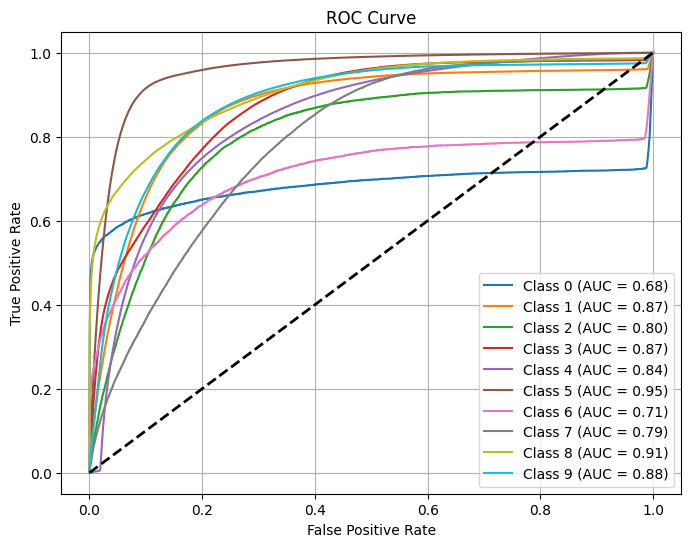

In [25]:
# Binarize the labels for multi-class ROC computation
all_labels_bin = label_binarize(roc_labels, classes=np.arange(class_num))

plt.figure(figsize=(8, 6))

# Compute ROC curve for each class
for i in range(class_num):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], roc_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

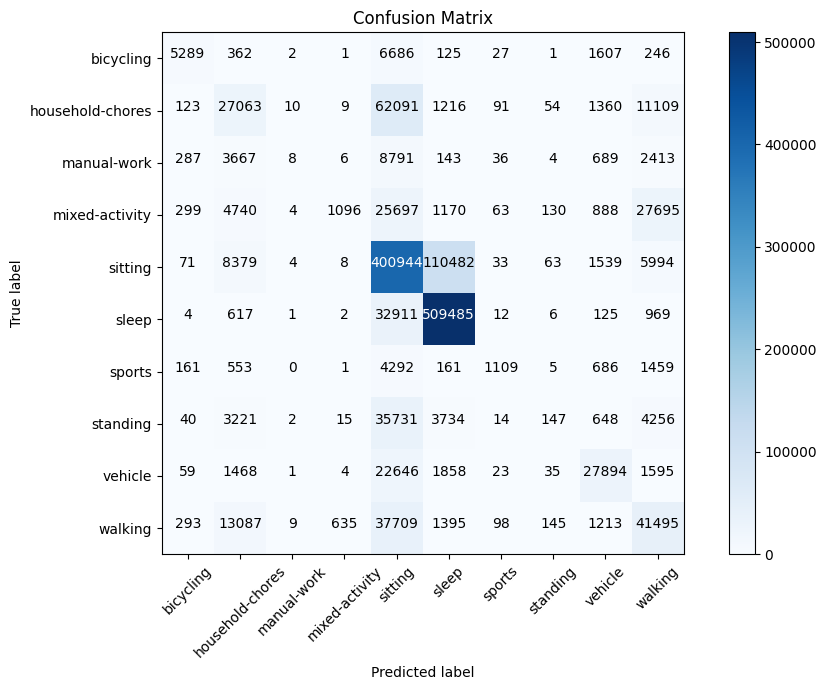

In [26]:
# Plotting the Confusion Matrix using Matplotlib
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Print the numbers in each cell of the matrix
    threshold = cm.max() / 2.  # Threshold for coloring
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_confusion_matrix(cm, label_encoder.classes_)

TEST THE TRAINED MODEL WITH TEST DATA

In [27]:
# Assuming you have a validation DataLoader set up
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)  # Replace with your validation dataset

# Evaluate the model
true_labels, predicted_labels, probs_labels, roc_probs, roc_labels = evaluate_model(model, test_loader, device)

In [28]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
# print("Confusion Matrix:\n", cm)

# Classification Report
report = classification_report(true_labels, predicted_labels, target_names=label_encoder.classes_)
print("Classification Report:\n", report)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy: {accuracy:.4f}")

# Compute AUC-ROC (one-vs-rest approach)
auc_roc = roc_auc_score(true_labels, probs_labels, multi_class='ovr')  
print(f"AUC-ROC Score: {auc_roc:.4f}")

Classification Report:
                   precision    recall  f1-score   support

       bicycling       0.80      0.39      0.52      3587
household-chores       0.43      0.26      0.32     25782
     manual-work       0.57      0.00      0.00      4011
  mixed-activity       0.63      0.02      0.04     15445
         sitting       0.63      0.76      0.69    131879
           sleep       0.81      0.94      0.87    136033
          sports       0.75      0.14      0.23      2106
        standing       0.27      0.00      0.01     11952
         vehicle       0.75      0.50      0.60     13896
         walking       0.43      0.44      0.43     24020

        accuracy                           0.69    368711
       macro avg       0.61      0.34      0.37    368711
    weighted avg       0.66      0.69      0.65    368711

Accuracy: 0.6886
AUC-ROC Score: 0.8297


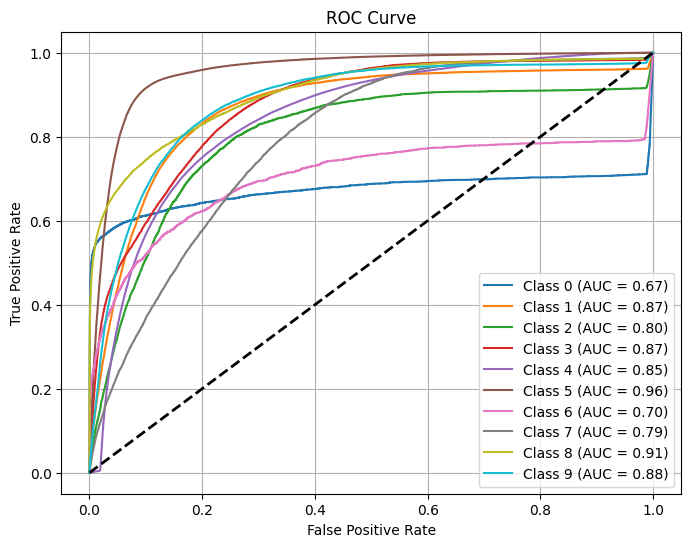

In [29]:
# Binarize the labels for multi-class ROC computation
all_labels_bin = label_binarize(roc_labels, classes=np.arange(class_num))

plt.figure(figsize=(8, 6))

# Compute ROC curve for each class
for i in range(class_num):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], roc_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot diagonal reference line
plt.plot([0, 1], [0, 1], 'k--', lw=2)

# Labels and title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()

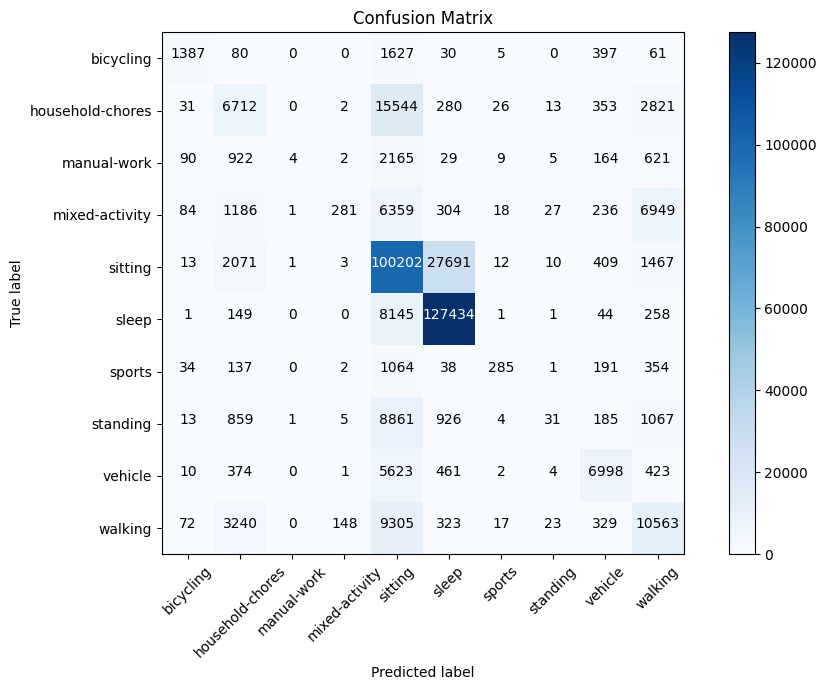

In [30]:
# Plotting the Confusion Matrix using Matplotlib
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 7))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Print the numbers in each cell of the matrix
    threshold = cm.max() / 2.  # Threshold for coloring
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > threshold else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Call the plot function
plot_confusion_matrix(cm, label_encoder.classes_)

In [31]:
# Convert the confusion matrix to a Pandas DataFrame with custom labels
cm_df = pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_)

# Display the confusion matrix
# print(cm_df)

cm_df.to_csv('confusion_matrix_acm_10.csv')

In [32]:
# Normalize by total samples to get percentages
cm_percentage = cm / cm.sum() * 100

# Normalize by row (class-wise normalization)
cm_percentage_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100

# Convert to DataFrame
cm_total_df = pd.DataFrame(cm_percentage, index=label_encoder.classes_, columns=label_encoder.classes_)
cm_row_df = pd.DataFrame(cm_percentage_row, index=label_encoder.classes_, columns=label_encoder.classes_)

# Save to CSV
cm_total_df.to_csv("confusion_matrix_acm_10_total_percentage.csv", index=True)
cm_row_df.to_csv("confusion_matrix_acm_10_row_percentage.csv", index=True)

SAVE THE TRAINED MODEL

In [33]:
# Save the entire model
# Assuming your model is loaded and `EvaClassifier` is defined as:
# model.classifier is the `EvaClassifier` instance
torch.save(model.classifier.state_dict(), 'acm_10.pth')

LOAD THE SAVED CLASSIFIER

In [32]:
# Define the same structure of `EvaClassifier`
class EvaClassifier(torch.nn.Module):
    def __init__(self):
        super(EvaClassifier, self).__init__()
        self.linear1 = torch.nn.Linear(512, 512)
        self.linear2 = torch.nn.Linear(512, 10)

    def forward(self, x):
        x = self.linear1(x)
        x = self.linear2(x)
        return x

# Create a new instance of the classifier
classifier = EvaClassifier()

# Load the state dictionary into the new instance
classifier.load_state_dict(torch.load('eva_classifier.pth'))

# Now `classifier` contains the saved weights


C:\Users\ali20\AppData\Local\Temp\ipykernel_3384\1414916956.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('eva_classifier.pth'))

<All keys matched successfully>

In [ ]:
# Reassign the classifier of the pretrained back to a model
model.classifier = classifier